# Проект: предсказание результата маркетинговой кампании банка

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача для специалиста Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# для работы с данными
import pandas as pd
import numpy as np
import re

# визуализация
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# предобработка, модели и метрики
from  sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna

%matplotlib inline
matplotlib.style.use('ggplot')

### Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [3]:
df = pd.read_csv('bank_fin.csv', sep = ';')
print(df.shape)
df.tail(5)

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no
11161,34,technician,married,secondary,no,0 $,no,no,cellular,9,jul,628,1,-1,0,unknown,no


In [4]:
# исследую данные на предмет пропусков

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None


In [5]:
# преобразую признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance'] = df['balance'].apply(lambda x: str(x))

list_for_replace = [' ', ',00$', ',00 $', '$']

for i in list_for_replace:
    df['balance'] = df['balance'].apply(lambda x: x.replace(i, ''))
    
df['balance'] = df['balance'].apply(lambda x: float(x))

In [6]:
# обрабатываю пропуски в признаке balance, заменив их медианными значениями

df.loc[(df['balance'].isnull()==True), 'balance'] = df['balance'].median()

In [7]:
# в признаке job и education есть пропуски в неявном виде
# (значение "unknown")

df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [8]:
# заменяю 'unknown' модальными значенями в этих признаках
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)

In [9]:
# считаю среднее значение баланса у пользователей 
# с самыми распространенными образованием и профессией (задача на курсе)
cond1 = df['job']=='management'
cond2 = df['education']=='secondary'
df[cond1 & cond2]['balance'].mean()

1598.8829787234042

#### Работа с аномальными значениями

In [10]:
# смотрю основные статистики по числовым признакам
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1526.936033,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3224.829691,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1699.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


В признаке balance виден большой разрыв между 75 квантилем и максимальным значением.

Посмотрим на распределение на гистограмме и Boxplot.

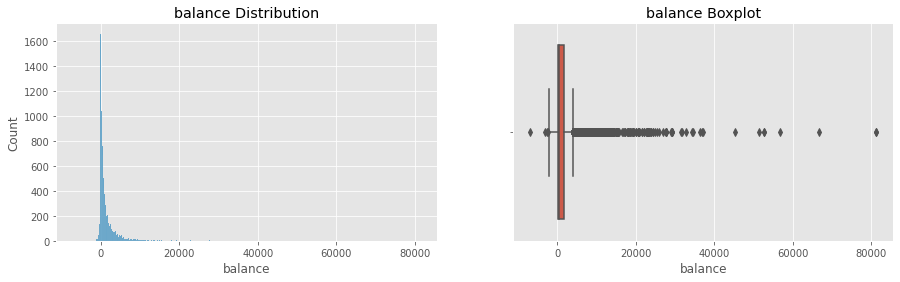

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
histplot = sns.histplot(data = df, x='balance', ax=axes[0])
histplot.set_title('balance Distribution')
boxplot = sns.boxplot(data = df, x='balance', ax=axes[1])
boxplot.set_title('balance Boxplot');


На графиках очевидно наличие выбросов в признаке. 

Исключим аномальные значения с помощью IQR. (Метод Тьюки)

In [12]:
# функция для очистки от аномальных значений на основе межквартильного размаха

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned

In [13]:
cleaned = outliers_iqr(df, 'balance')

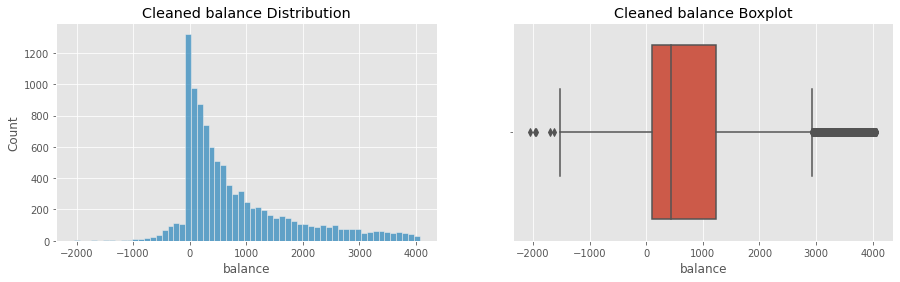

In [14]:
# смотрю распределение после очистки

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0])
histplot.set_title('Cleaned balance Distribution')
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1])
boxplot.set_title('Cleaned balance Boxplot');

## Часть 2:  Разведывательный анализ

Начну изучение с целевого признака.

Посмотрю сбалансированность классов.\
Предварительно переведу таргет в числовой вид для удобной работы в дальнейшем.

In [15]:
# переведу таргет в числовой вид. (0 и 1)
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [16]:
# смотрю соотношение классов
cleaned['deposit'].value_counts()

0    5424
1    4681
Name: deposit, dtype: int64

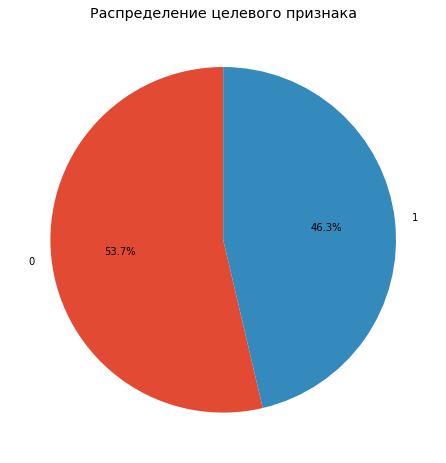

In [17]:
# строю круговую диаграмму для визуализации соотношения классов

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((1, 1, 1, 1))

deposit_pie = ax.pie(
    cleaned['deposit'].value_counts(),
    labels = cleaned['deposit'].value_counts().index,
    autopct='%1.1f%%',
    startangle=90
    )

ax.set_title('Распределение целевого признака');

Виден незначительный перевес в пользу неоткрывших депозит.\
Пока решаю пренебречь.

Посмотрим на остальные признаки.

In [18]:
# вновь смотрю описательные статистики для количественных переменных
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous,deposit
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000


В признаке *age* все выглядит более-менее адекватно. Значения от 18 до 95 лет с медианой в 38.

Переменная *balance* уже очищена от выбросов, однако смещение среднего относительно медианы все еще наблюдается.

*day* - все ок. Значения от 1 до 31 с медианой и средним в 15.

*duration* - пока слонжо что-то сказать о продолжительности разговора в секундах.\
3881 - подозрительно много. Никогда не говорил с банком больше часа :) Посмотрю на распределение.

*campaign, pdays и previous* также требуют детального изучения.

Начну по порядку. Возраст.\
Для рассмотрения зависимости таргета от возраста клента понадобится перевести признак в диапазоновый вид.

In [19]:
def get_age_groups(age):
    '''функция для получения возрастных групп'''
    if age < 30:
        age_group = '<30'
    if 30 <= age < 40:
        age_group = '30-39'
    if 40 <= age < 50:
        age_group = '40-49'
    if 50 <= age < 60:
        age_group = '50-59'
    if 60 <= age:
        age_group = '60+'
    
    return age_group

In [20]:
# преобразую признак
cleaned['age'] = cleaned['age'].apply(lambda x: get_age_groups(x))

In [21]:
# смотрю распределение целевой переменной от возраста
by_age = cleaned.groupby('age', as_index=False)['deposit'].value_counts()
by_age

,age,deposit,count
0,30-39,0,2245
1,30-39,1,1716
2,40-49,0,1444
3,40-49,1,938
4,50-59,0,984
5,50-59,1,670
6,60+,1,496
7,60+,0,157
8,<30,1,861
9,<30,0,594


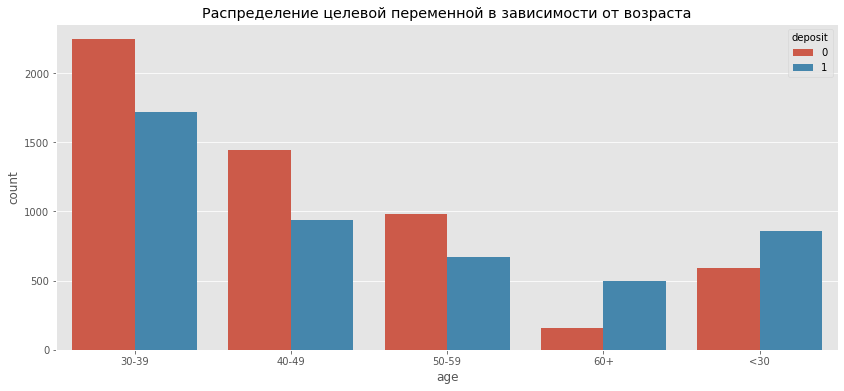

In [22]:
# визуализирую результат для наглядности

fig, axes = plt.subplots(figsize=(14,6))
bar = sns.barplot(
    data=by_age,
    x='age',
    y='count',
    hue='deposit'
                  )

bar.set_title('Распределение целевой переменной в зависимости от возраста');

Из графика видим, что наиболее склонными к открытию депозита в нашей выборке\
оказались люди до 30 и старше 60 лет. Однако количественно в выборке их меньше.

Дальше посмотрю как распределен баланс у открывших депозит и отказавшихся.

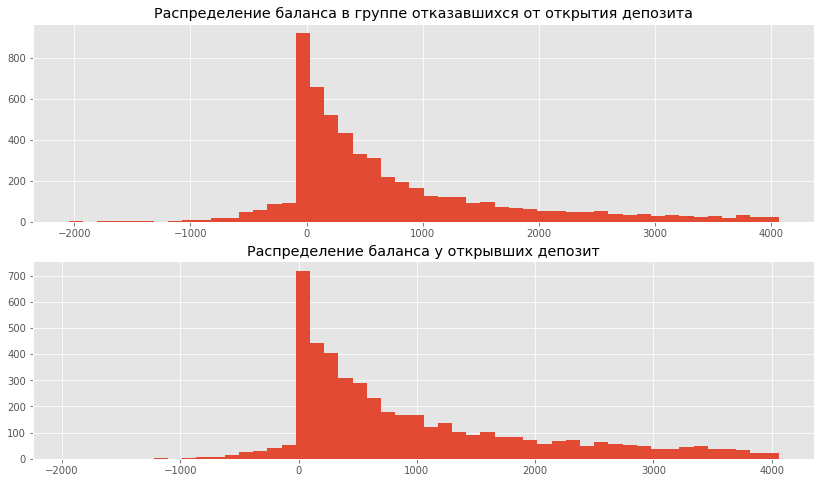

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8))
ax1.hist(cleaned.query('deposit==0')['balance'], bins=50)
ax1.set_title('Распределение баланса в группе отказавшихся от открытия депозита')
ax2.hist(cleaned.query('deposit==1')['balance'], bins=50)
ax2.set_title('Распределение баланса у открывших депозит');

Никаких ощутимых различий здесь не наблюдаю.

Перехожу к *duration*.

In [24]:
print('Средняя продолжительность разговора в классе 0:', cleaned.query('deposit==0')['duration'].mean())
print('Средняя продолжительность разговора в классе 1:', cleaned.query('deposit==1')['duration'].mean())

Средняя продолжительность разговора в классе 0: 221.31674041297936
Средняя продолжительность разговора в классе 1: 539.568895535142


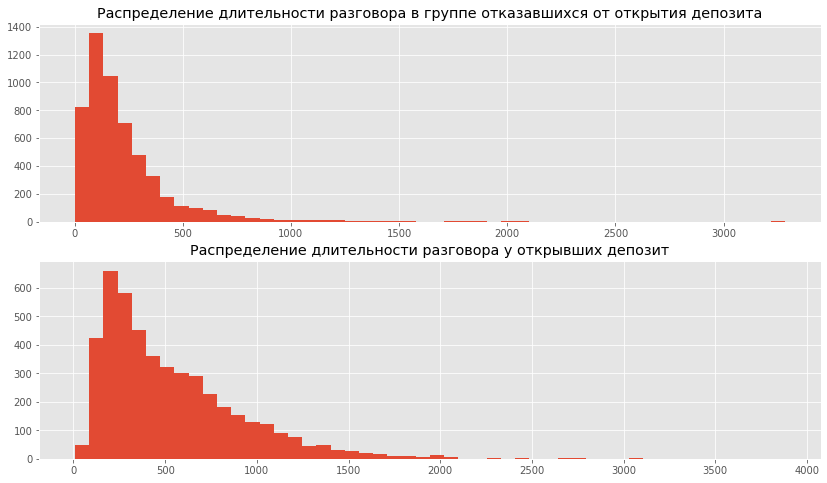

In [25]:
# визуализирую распределение признака в группах

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8))
ax1.hist(cleaned.query('deposit==0')['duration'], bins=50)
ax1.set_title('Распределение длительности разговора в группе отказавшихся от открытия депозита')
ax2.hist(cleaned.query('deposit==1')['duration'], bins=50)
ax2.set_title('Распределение длительности разговора у открывших депозит');

Как и ожидалось, длительность разговора с клиентами, открывшими депозит, в среднем выше, чем в группе отказавшихся.\
539 против 221 секунды соответственно.\
Также на графике видно наличие аномальных значений. Избавлюсь от них вручную,\
так как IQR отрежет большую часть данных.

In [26]:
cleaned = cleaned.query('duration<2500')

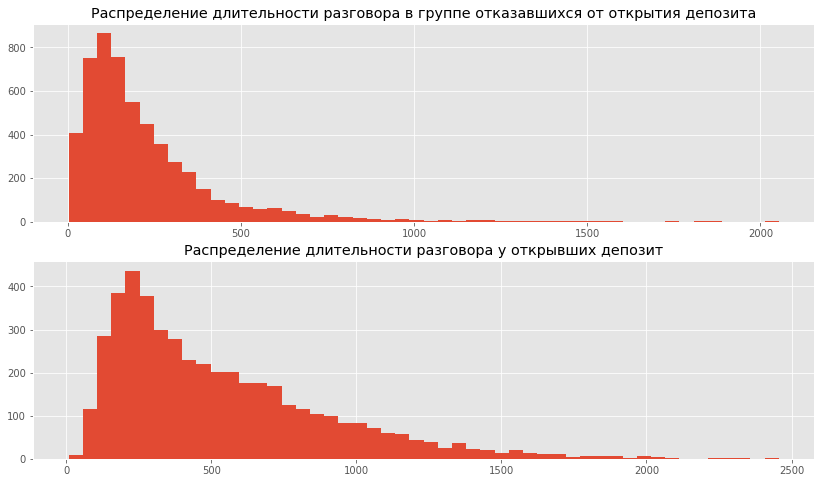

In [27]:
# снова смотрю на графики 
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,8))
ax1.hist(cleaned.query('deposit==0')['duration'], bins=50)
ax1.set_title('Распределение длительности разговора в группе отказавшихся от открытия депозита')
ax2.hist(cleaned.query('deposit==1')['duration'], bins=50)
ax2.set_title('Распределение длительности разговора у открывших депозит');

Различия в группах стали более очевидны.

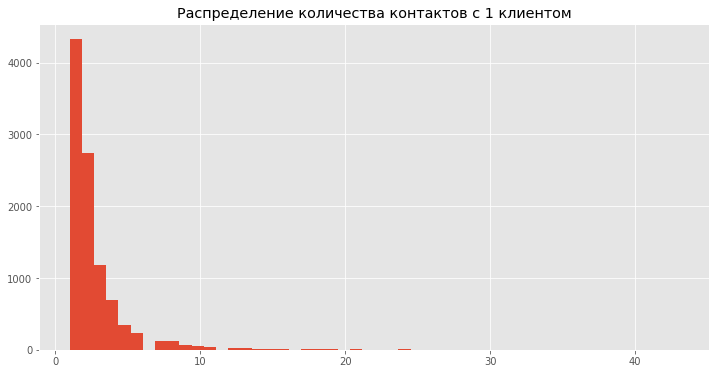

In [28]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(cleaned['campaign'], bins=50)
ax.set_title('Распределение количества контактов с 1 клиентом');

In [29]:
# также вручную "отрежу" правую часть

cleaned = cleaned.query('campaign<20')

Признак *pdays*

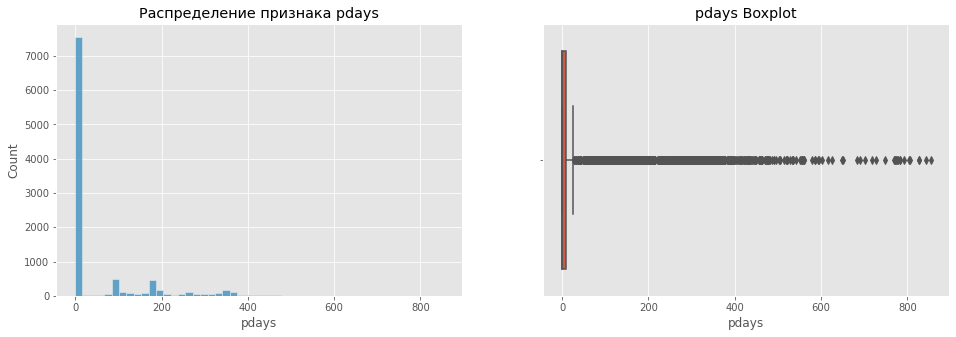

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

histplot = sns.histplot(data=cleaned, x='pdays', bins=50, ax=axes[0])
histplot.set_title('Распределение признака pdays')
boxplot = sns.boxplot(data=cleaned, x='pdays', ax=axes[1])
boxplot.set_title('pdays Boxplot');

In [31]:
# топ значений в признаке pdays
cleaned.pdays.value_counts(normalize=True).head()

-1      0.747487
 92     0.008759
 182    0.007664
 181    0.007465
 91     0.007365
Name: pdays, dtype: float64

Если честно, пока вообще не понимаю что тут происходит, и как с последней кампании до первого контакта\
в настоящей кампании могло пройти -1 день. (Почти 75% значений в выборке.)\
Пока оставлю, но, возможно, придется удалить.

Посмотрим на *previous*

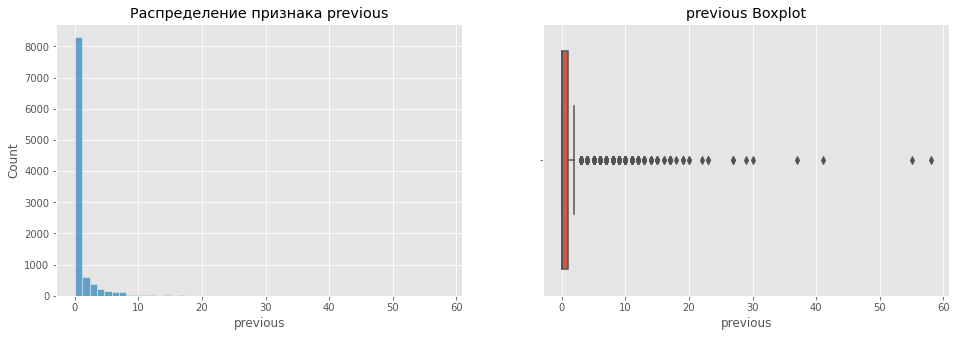

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

histplot = sns.histplot(data=cleaned, x='previous', bins=50, ax=axes[0])
histplot.set_title('Распределение признака previous')
boxplot = sns.boxplot(data=cleaned, x='previous', ax=axes[1])
boxplot.set_title('previous Boxplot');

In [33]:
# топ значений в признаке previous
cleaned.previous.value_counts(normalize=True).head()

0    0.747487
1    0.079228
2    0.060914
3    0.038917
4    0.022196
Name: previous, dtype: float64

В данном случае можно увидеть, что почти 75% клиентов - новые для банка, так как взаимодействий ранее с ними не было.\
Также доля этих клиентов полностью совпадает с долей значения "-1" в признаке pdays.\
Можно предположить, что это одни и те же обьекты. Выясним это позже.

### Категориальные признаки

In [34]:
# посмотрим описательные статистики для категориальных переменных
cleaned.describe(include='object')

,age,job,marital,education,default,housing,loan,contact,month,poutcome
count,10047,10047,10047,10047,10047,10047,10047,10047,10047,10047
unique,5,11,3,3,2,2,2,3,12,4
top,30-39,management,married,secondary,no,no,no,cellular,may,unknown
freq,3941,2301,5677,5484,9884,5219,8669,7253,2610,7512


С возрастом мы уже разобрались. Начну со сферы занятости - *job*.

Посмотрю люди каких профессий чаще соглашались открыть депозит.

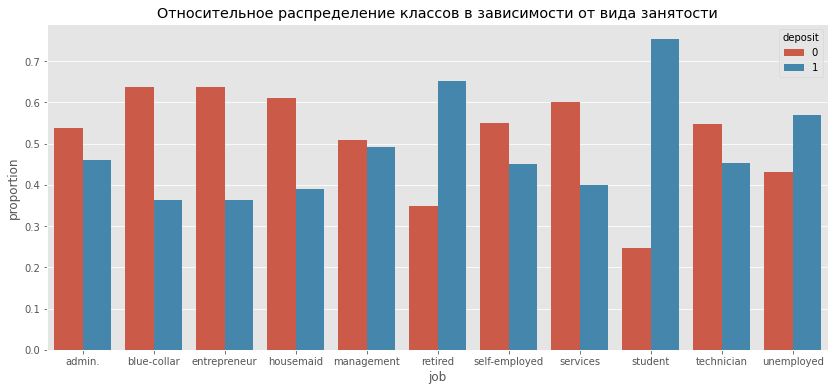

In [35]:
# как распределены абсолютные значения в признаке мы уже видели
# визуализирую открывших и неоткрывших депозит в зависимости от вида занятости
by_job = cleaned.groupby('job', as_index=False)['deposit'].value_counts(normalize=True)

fig, axes = plt.subplots(figsize=(14,6))
bar = sns.barplot(
    data=by_job,
    x='job',
    y='proportion',
    hue='deposit'
                  )

bar.set_title('Относительное распределение классов в зависимости от вида занятости');

График показывает, что наиболее склонны к открытию депозита студенты и люди в отставке,\
что совпадает с результатами аналогичного графика по возрасту.\
Также согласие на открытие депозита часто давали безработные люди.

Далее изучим информацию о семейном статусе.

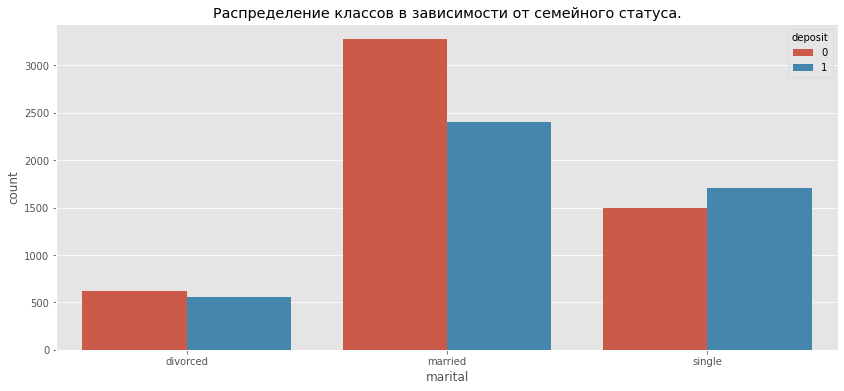

In [36]:
# построю визуализацию результатов кампании в зависимости от семейного статуса
by_marital = cleaned.groupby('marital', as_index=False)['deposit'].value_counts()

fig, axes = plt.subplots(figsize=(14,6))
bar = sns.barplot(
    data=by_marital,
    x='marital',
    y='count',
    hue='deposit'
                  )
bar.set_title('Распределение классов в зависимости от семейного статуса.');

Видим из графика, что одинокие люди открывали депозит чаще остальных.

Проделаем тоже самое для *education*.

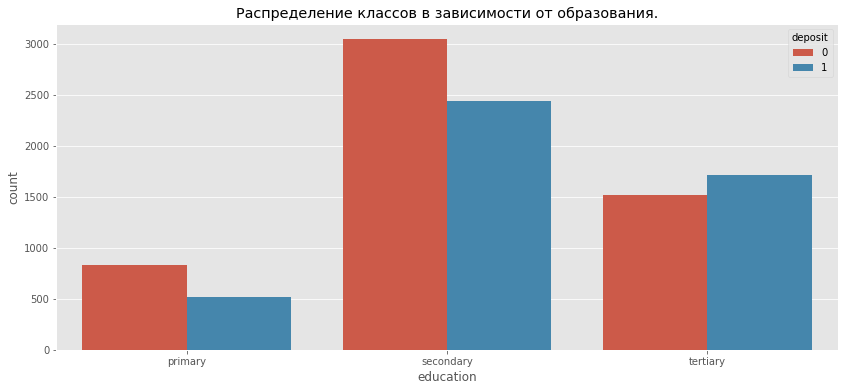

In [37]:
# визуализация для открывших и неоткрывших депозит в зависимости от образования
by_education = cleaned.groupby('education', as_index=False)['deposit'].value_counts()

fig, axes = plt.subplots(figsize=(14,6))
bar = sns.barplot(
    data=by_education,
    x='education',
    y='count',
    hue='deposit'
                  )
bar.set_title('Распределение классов в зависимости от образования.');

Видим из графика, что люди с высшим образованием соглашались на открытие депозита чаще остальных.

Перейдем к бинарным признакам *default*, *housing* и *loan*

In [38]:
print('Значения признака default: \n', cleaned['default'].value_counts(), '\n')
print('Значения признака housing: \n', cleaned['housing'].value_counts(), '\n')
print('Значения признака loan: \n', cleaned['loan'].value_counts(), '\n')

Значения признака default: 
 no     9884
yes     163
Name: default, dtype: int64 

Значения признака housing: 
 no     5219
yes    4828
Name: housing, dtype: int64 

Значения признака loan: 
 no     8669
yes    1378
Name: loan, dtype: int64 



Видим, что дефолтных клиентов совсем незначительное количество.\
Клиентов с кредитом на жилье и без него примерно поровну.\
А вот людей с потребительским кредитом значительно меньше.\

Рассмотрим взаимосвязь признаков с результатом.

Text(0.5, 1.0, 'Результат в зависимости от дефолта.')

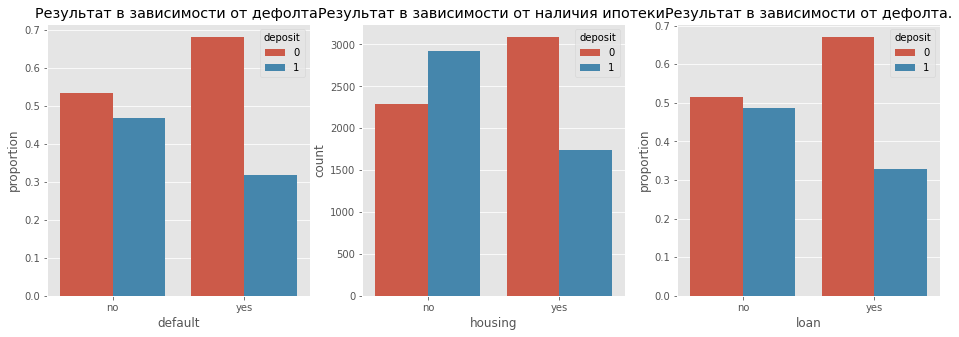

In [39]:
# default и loan считаю с нормализацией, так как слишком большой "перевес" сторону одного класса

by_default = cleaned.groupby('default', as_index=False)['deposit'].value_counts(normalize=True)
by_housing = cleaned.groupby('housing', as_index=False)['deposit'].value_counts()
by_loan = cleaned.groupby('loan', as_index=False)['deposit'].value_counts(normalize=True)

fig, axes = plt.subplots(1, 3, figsize=(16,5))
bar1 = sns.barplot(data=by_default, x='default', y='proportion', hue='deposit', ax=axes[0])
bar1.set_title('Результат в зависимости от дефолта.')
bar2 = sns.barplot(data=by_housing, x='housing', y='count', hue='deposit', ax=axes[1])
bar2.set_title('Результат в зависимости от наличия ипотеки.')
bar3 = sns.barplot(data=by_loan, x='loan', y='proportion', hue='deposit', ax=axes[2])
bar3.set_title('Результат в зависимости от дефолта.')

Из графиков видим, что люди с дефолтом в прошлом реже соглашаются на открытие депозита.\
Также депозит чаще открывают клиенты без ипотеки и без потребительского кредита.

Перехожу к изучению признака *month*.

In [40]:
# посмотрю на соотношение значений сначала в абсолютном виде
cleaned['month'].value_counts()

may    2610
jul    1397
aug    1375
jun    1091
apr     830
nov     780
feb     706
oct     333
jan     318
sep     278
mar     236
dec      93
Name: month, dtype: int64

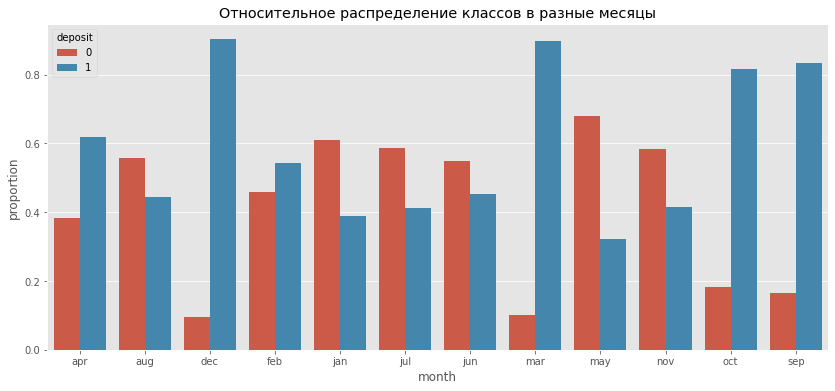

In [41]:
# смотрю в каком месяце чаще всего соглашались открыть депозит
by_month = cleaned.groupby('month', as_index=False)['deposit'].value_counts(normalize=True)

fig, axes = plt.subplots(figsize=(14,6))
bar = sns.barplot(
    data=by_month,
    x='month',
    y='proportion',
    hue='deposit'
                  )
bar.set_title('Относительное распределение классов в разные месяцы');

Из абсолютных значений видим, что больше всего контактов совершалось в летние месяцы, \
однако самыми результативными были сентябрь, октябрь, декабрь и март.

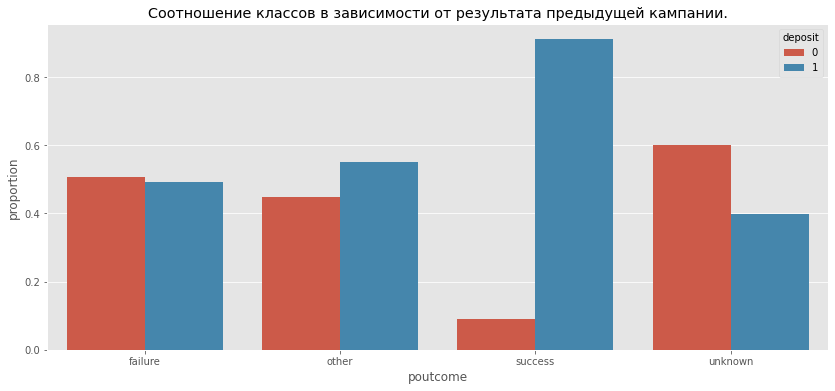

In [42]:
# смотрю для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
by_poutcome = cleaned.groupby('poutcome', as_index=False)['deposit'].value_counts(normalize=True)

fig, axes = plt.subplots(figsize=(14,6))
bar = sns.barplot(
    data=by_poutcome,
    x='poutcome',
    y='proportion',
    hue='deposit'
                  )
bar.set_title('Соотношение классов в зависимости от результата предыдущей кампании.');

Здесь видим, что результаты предыдущей кампании примерно коррелируют с результатми настоящей. \
Клиенты, которые были успешно вовлечены в предыдущую кампанию, открывали депозит гораздо чаще,\
чем представители других групп.

In [43]:
# строю сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(среди тех, кто открыл депозит)

deposit = cleaned.query('deposit == 1')

pivot = pd.pivot_table(deposit,
                       values='deposit',
                       index='education',
                       columns='marital',
                       aggfunc='count')

pivot

marital,divorced,married,single
education,,,
primary,96,337,81
secondary,282,1283,876
tertiary,174,782,753


## Часть 3: преобразование данных

Целевую переменную мы уже закодировали ранее.\
Остальные признаки типа object нужно перевести в числовой вид.

In [44]:
# преобразую возраст порядковым кодированием

le = LabelEncoder()

le.fit(cleaned['age'])
cleaned['age'] = le.transform(cleaned['age'])

In [45]:
# также кодирую уровни образования

le.fit(cleaned['education'])
cleaned['education'] = le.transform(cleaned['education'])

In [46]:
# бинарные признаки закодирую вручную для логического соответствия
# для корректного преобразования пришлось предварительно избавить значения от пробелов

binary = ['default', 'housing', 'loan']

for i in binary:
    cleaned[i] = cleaned[i].apply(lambda x: str(x).strip())

for i in binary:
    cleaned[i] = cleaned[i].apply(lambda x: 1 if x=='yes' else 0)

In [47]:
# создаю дамми-переменные
cols = ['job', 'marital', 'contact', 'month', 'poutcome']

dummies = pd.get_dummies(cleaned, columns=cols)

# проверяю что с данными все в порядке
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10047 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10047 non-null  int32  
 1   education          10047 non-null  int32  
 2   default            10047 non-null  int64  
 3   balance            10047 non-null  float64
 4   housing            10047 non-null  int64  
 5   loan               10047 non-null  int64  
 6   day                10047 non-null  int64  
 7   duration           10047 non-null  int64  
 8   campaign           10047 non-null  int64  
 9   pdays              10047 non-null  int64  
 10  previous           10047 non-null  int64  
 11  deposit            10047 non-null  int64  
 12  job_admin.         10047 non-null  uint8  
 13  job_blue-collar    10047 non-null  uint8  
 14  job_entrepreneur   10047 non-null  uint8  
 15  job_housemaid      10047 non-null  uint8  
 16  job_management     100

Text(0.5, 1.0, 'Тепловая карта корреляций между признаками')

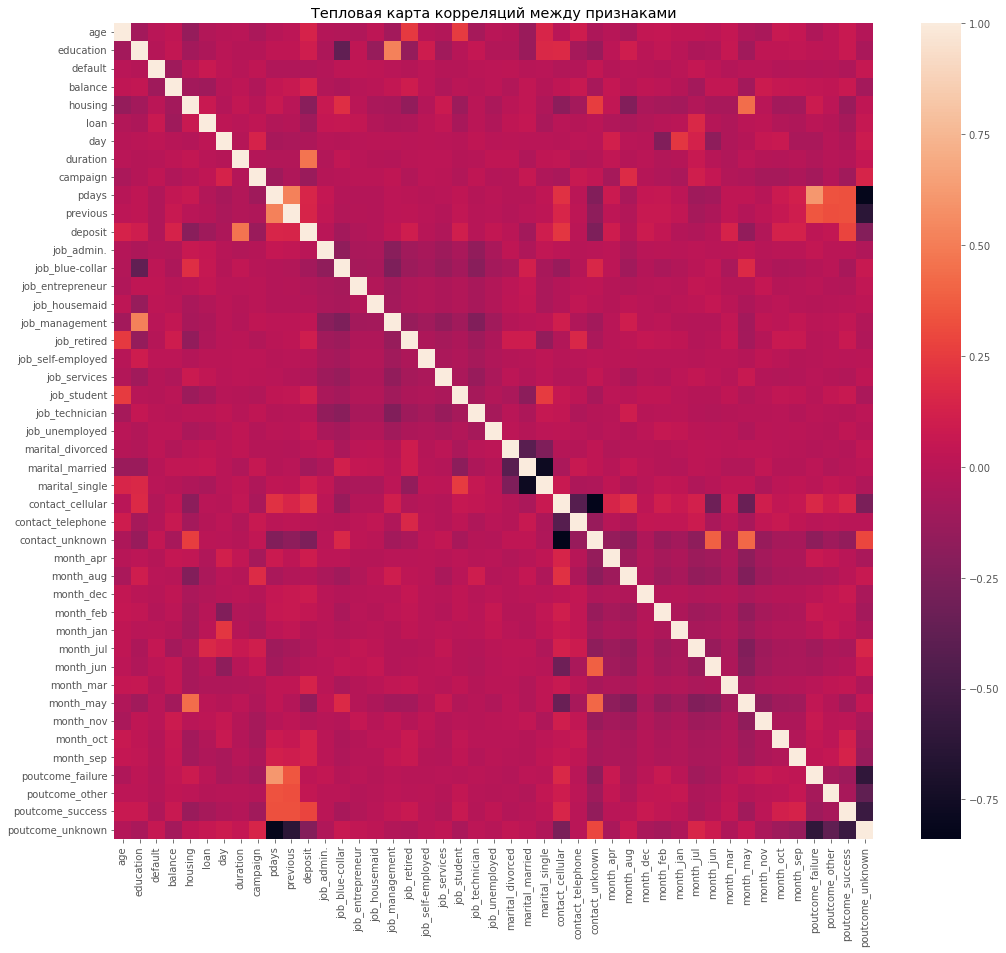

In [48]:
# строю корреляционную матрицу и визуализирую на тепловой карте
# чтобы проверить наличие мультиколлинеарности

fig, axes = plt.subplots(figsize=(17,15))
corr_matrix = sns.heatmap(dummies.corr())
corr_matrix.set_title('Тепловая карта корреляций между признаками')

Из тепловой карты можно увидеть, что мультиколлинераности (сильно скоррелированных признаков) в данных нет.\

Самую большую созависимость с целевой переменной имеют признаки *duration*, *poutcome_success* и *contact_cellular*.\
Большая часть признаков практически не оказывают никакого влияния на таргет.

In [49]:
# разделяю таргет и матрицу признаков

X = dummies.drop(['deposit'], axis=1)
y = dummies['deposit']

In [50]:
# с помощью SelectKBest отбираю 15 наиболее подходящих признаков

skb = SelectKBest(f_classif, k=15).fit(X, y)
best_features = skb.get_feature_names_out().tolist()
X_new = pd.DataFrame(skb.transform(X), columns=best_features)

X_new.head()

,age,balance,housing,duration,campaign,pdays,previous,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
0,2.0,2343.0,1.0,1042.0,1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2.0,45.0,0.0,1467.0,1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1270.0,1.0,1389.0,1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2.0,2476.0,1.0,579.0,1.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2.0,184.0,0.0,673.0,2.0,-1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [51]:
# выделяю тестовую выборку

X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, random_state = 42, test_size = 0.33)

In [52]:
# нормализую данные

mmscaler = preprocessing.MinMaxScaler()

mmscaler.fit(X_train)
X_train_norm = pd.DataFrame(mmscaler.transform(X_train), columns=best_features)
X_test_norm = pd.DataFrame(mmscaler.transform(X_test), columns=best_features)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Данные подготовлены. Перехожу к построению моделей.\
Начинаю с простых. Попробую обучить логистическую регрессию и решающее дерево.

In [53]:
# обучаю логистическую регрессию и считаю accuracy

logr = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000
    )

logr.fit(X_train_norm, y_train)
y_pred_lr = logr.predict(X_test_norm)

metrics.accuracy_score(y_test, y_pred_lr)

0.8175512665862484

Неплохой результат для начала. Посмотрим на DecisionTree.

In [54]:
# обучаю решающее дерево
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train_norm, y_train)
y_train_pred_dt = dt.predict(X_train_norm)
y_pred_dt = dt.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred_dt))
print(metrics.accuracy_score(y_test, y_pred_dt))

1.0
0.4583835946924005


На лицо - переобучение. На тренировочной выборке идеальный результат, на тесте - все плохо.\
Попробую исправить это настройкой гиперпараметров.

In [63]:
# подбираю оптимальные параметры с помощью gridsearch

grid = {'min_samples_split': [2, 5, 7, 10],
        'max_depth':[3,5,7,13]}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=grid,
    n_jobs = -1
)

grid_search.fit(X_train_norm, y_train)
grid_pred = grid_search.predict(X_test_norm)
print(metrics.classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1777
           1       0.80      0.82      0.81      1539

    accuracy                           0.82      3316
   macro avg       0.82      0.82      0.82      3316
weighted avg       0.82      0.82      0.82      3316



Переобучение победили, но заметно улучшить результат не удалось.\
Поробую использовать более сложные модели для прогноза.

# Часть 5: Ансамбли моделей и построение прогноза

Самые очевидные решения здесь - случайный лес и градиентный бустинг.\
Затем попробую соединить несколько разных моделей на стекинге.

In [56]:
# обучаю случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
    )

rf.fit(X_train_norm, y_train)
rf_pred = rf.predict(X_test_norm)

print(metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1777
           1       0.81      0.83      0.82      1539

    accuracy                           0.83      3316
   macro avg       0.83      0.83      0.83      3316
weighted avg       0.83      0.83      0.83      3316



In [57]:
# пробую градиентный бустинг

gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gb.fit(X_train_norm, y_train)
gb_pred = gb.predict(X_test_norm)

print(metrics.classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1777
           1       0.81      0.85      0.83      1539

    accuracy                           0.84      3316
   macro avg       0.84      0.84      0.84      3316
weighted avg       0.84      0.84      0.84      3316



Пока что бустинг показал лучшие результаты.\
Попробую "состекать" все, что уже обучил.

In [58]:
# объединяю уже испробованные алгоритмы с помощью стекинга
stack = ensemble.StackingClassifier(
    estimators = [('lr', logr), ('rf', rf), ('gb', gb)],
    final_estimator = linear_model.LogisticRegression(
        solver='sag', 
        random_state=42, 
        max_iter=1000)
)

stack.fit(X_train_norm, y_train)
stack_pred = stack.predict(X_test_norm)

print(metrics.classification_report(y_test, stack_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1777
           1       0.82      0.83      0.83      1539

    accuracy                           0.84      3316
   macro avg       0.84      0.84      0.84      3316
weighted avg       0.84      0.84      0.84      3316



В случае со стекингом мы получили прибавку в точности определения класса 1 (открытие депозита),\
однако, что логично, потеряли в полноте (recall), относительно тех же метрик в бустинге.

Поскольку цена ошибки по условиям задачи мне неизвестна, пробую рассуждать логически:
- Неверно предсказать открытие депозита (класс 1) - значит потратить ресурсы банка на привлечение клиента.
Например, это звонок или время сотрудника на личной встрече с клиентом.
- Неверно предсказать отказ (класс 0) - означет упущенную прибыль банка.

Предположу, что цена второй ошибки больше.\
Следовательно, в данной задаче стоит сделать выбор в пользу той модели, которая охватывает как можно больше клиентов в классе 1.\
А значит, свой выбор остановим на градиентном бустинге, так как полнота предсказания класса 1 в данной модели выше на 2%.

Наконец, попробую оптимизировать параметры выбранной модели с помощью библиотеки Optuna.

In [66]:
# функция для подбора параметров модели с помощью библиотеки Optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 150, 300, 1)
  max_depth = trial.suggest_int('max_depth', 3, 10, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10, 1)

  model = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_leaf=min_samples_leaf,
                                              random_state=42)

  model.fit(X_train_norm, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_norm))

  return score

In [ ]:
study = optuna.create_study(study_name="GradientBoostingClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на тестовом наборе: {:.2f}".format(study.best_value))

In [69]:
# обучаю бустинг на лучших параметрах
model = ensemble.GradientBoostingClassifier(**study.best_params,random_state=42)
model.fit(X_train_norm, y_train)
y_test_pred = model.predict(X_test_norm)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1777
           1       0.81      0.85      0.83      1539

    accuracy                           0.84      3316
   macro avg       0.84      0.84      0.84      3316
weighted avg       0.84      0.84      0.84      3316



Итак, результат с помощью оптимизации гиперпараметров улучшить не удалось.\
И все же градиентный бустинг показал наилучший результат из всех испробованных моделей,\
поэтому остановим свой выбор на нем.

Конечно, модель можно пытаться совершенствовать и дальше: пробовать другие модели МО,\
попытаться создать дополнительные признаки и так далее. Совершенству нет предела.

Мое решение дает правильное предсказание в 84% случаев.\
Достаточный это показатель или нет - в каждом случае решает заказчик. (Полагаю :) )

Так как это первый самостоятельный проект по ML, буду считать эту метрику приемлемой.